In [1]:
import numpy as np
import os, re, sys
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier

In [2]:
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)

In [4]:
# in a well-defined initial state.
random.seed
np.random.seed(1337)

In [5]:
all_pep, all_mhc, all_target = np.load('/home/jjia1/jjia1/viralepitope/all_pep_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_mhc_converted.npy'), np.load('/home/jjia1/jjia1/viralepitope/all_target_converted.npy')

In [6]:
def balanced_sampling(pep, mhc, target):
    pos = np.where(target==1)
    neg = np.where(target==0)

    pep_pos, mhc_pos, target_pos = pep[pos], mhc[pos], target[pos]
    pep_neg, mhc_neg, target_neg = pep[neg], mhc[neg], target[neg]

    pep_pos, mhc_pos, target_pos = resample(pep_pos, mhc_pos, target_pos, n_samples= len(target_pos), random_state = 1337)
    pep_neg, mhc_neg, target_neg = resample(pep_neg, mhc_neg, target_neg, n_samples= len(target_pos), random_state = 1337)


    pep = np.concatenate([pep_pos, pep_neg])
    mhc = np.concatenate([mhc_pos, mhc_neg])
    target = np.concatenate([target_pos, target_neg])

    pep, mhc, target = shuffle(pep, mhc, target, random_state = 1337)
    return pep, mhc, target
    
pep_bal, mhc_bal, target_bal = balanced_sampling(all_pep, all_mhc, all_target)

In [7]:
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(pep_bal, mhc_bal, target_bal, test_size = 0.2, stratify= target_bal)

In [6]:
train_pep, test_pep, train_mhc, test_mhc, train_target, test_target = train_test_split(all_pep, all_mhc, all_target, test_size = 0.2, stratify= all_target)

In [7]:
train_pep.shape

(756347, 30, 20)

In [8]:
train_pep_reshaped = train_pep.reshape(train_pep.shape[0], (train_pep.shape[1]*train_pep.shape[2]))
train_mhc_reshaped = train_mhc.reshape(train_mhc.shape[0], (train_mhc.shape[1]*train_mhc.shape[2]))

In [9]:
print(train_pep_reshaped.shape)
print(train_mhc_reshaped.shape)

(756347, 600)
(756347, 680)


In [10]:
train_data = np.column_stack((train_pep_reshaped, train_mhc_reshaped))

In [11]:
print(train_data.shape)

(756347, 1280)


In [12]:
train_data, train_target = shuffle(train_data, train_target)

In [13]:
rf = RandomForestClassifier(random_state = 1337)

In [14]:
rf.fit(train_data, train_target)

RandomForestClassifier(random_state=1337)

In [15]:
test_pep_reshaped = test_pep.reshape(test_pep.shape[0], (test_pep.shape[1]*test_pep.shape[2]))
test_mhc_reshaped = test_mhc.reshape(test_mhc.shape[0], (test_mhc.shape[1]*test_mhc.shape[2]))
test_data = np.column_stack((test_pep_reshaped, test_mhc_reshaped))
test_data, test_target = shuffle(test_data, test_target)

In [16]:
pred = rf.predict_proba(test_data)

In [17]:
fpr, tpr, _ = roc_curve(test_target, pred[:,1])
auroc = roc_auc_score(test_target, pred[:,1])
pr, rc, _ = precision_recall_curve(test_target, pred[:,1])
aupr = average_precision_score(test_target, pred[:,1])

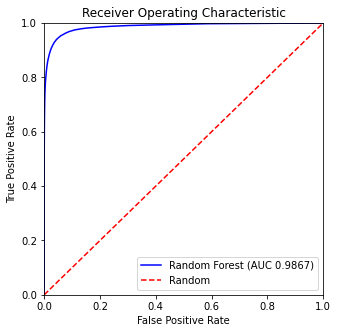

In [18]:
# method I: plt
plt.figure(figsize=(5,5))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'Random Forest (AUC %0.4f)' %auroc)
plt.plot([0, 1], [0, 1],'red', label = 'Random', linestyle = 'dashed')

plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

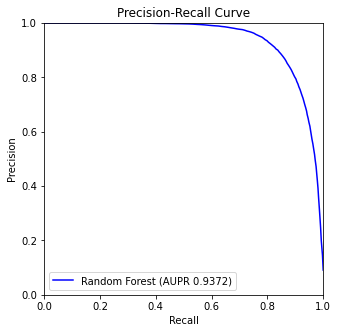

In [19]:
# method I: plt
plt.figure(figsize=(5,5))
plt.title('Precision-Recall Curve')
plt.plot(rc, pr, 'b', label = 'Random Forest (AUPR %0.4f)' %aupr)

plt.legend(loc = 'lower left')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1337)    
allprobas_=np.array([]) 
all_labels=np.array([])

In [ ]:
for i, (train, test) in enumerate(kfold.split(train_pep, train_target)):
    rf = RandomForestClassifier(random_state = 1337)
    
    train_pep_reshaped = train_pep.reshape(train_pep.shape[0], (train_pep.shape[1]*train_pep.shape[2]))
    train_mhc_reshaped = train_mhc.reshape(train_mhc.shape[0], (train_mhc.shape[1]*train_mhc.shape[2]))
    train_data = np.column_stack((train_pep_reshaped, train_mhc_reshaped))
    train_data, train_target = shuffle(train_data, train_target)

    training_pep = train_pep_reshaped[train]
    training_mhc = train_mhc_reshaped[train]
    training_target = train_target_reshaped[train]
    
    validation_pep = train_pep[test]
    validation_mhc = train_mhc[test]
    validation_target = train_target[test]


    rf.fit(train_data, train_target)

    pred = rf.predict_proba(validation_target)
    np.append(all_probas, pred)
    np.append(all_labels, validation_target)